# EDA

In [1]:
import os
import pandas as pd
import plotly.express as px
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
import pickle as pkl

In [2]:
os.chdir("../../")

In [3]:
from lib.config import config
from lib.utils.utils import seed_everything
from lib.paths import Paths
from lib.data_tools.data import clean_text

In [4]:
seed_everything()

## Loading datasets

In [5]:
train_df = pd.read_csv(Paths.COMPETITION_TRAIN_CSV_PATH)
test_df = pd.read_csv(Paths.COMPETITION_TEST_CSE_PATH)

train_df.shape, test_df.shape

((17307, 3), (3, 2))

In [6]:
train_df.columns

Index(['essay_id', 'full_text', 'score'], dtype='object')

### Processing

In [7]:
train_df["full_text"] = train_df["full_text"].map(lambda x: x.strip())
test_df["full_text"] = test_df["full_text"].map(lambda x: x.strip())

## Topic Modeling

Followed [BERTopic best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html#additional-representations)

### Data Processing

Splitting essays into paragraphs.

In [8]:
# paragraph_df = train_df.copy(deep=True)
# paragraph_df["full_text"] = paragraph_df["full_text"].map(lambda x: x.split("\n\n"))
# paragraph_df = paragraph_df.explode("full_text").reset_index()
# paragraph_df["full_text"] = paragraph_df['full_text'].map(clean_text)
# paragraph_df.shape

### Precalculating Embeddings

In [9]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(train_df["full_text"], show_progress_bar=True)

Batches:   0%|          | 0/541 [00:00<?, ?it/s]

### Preventing Stochastic Behavior

In [10]:
umap_model = UMAP(
    n_neighbors=15, # larger = Global trends, smaller = local trends
    n_components=5, # The dimension of the space to embed into. 
    min_dist=0.0, # larger = even dispersal of points, smaller = more clustered/clumped embedding
    metric="cosine", 
    random_state=config.random_seed,
)

### Controlling Number of Topics

In [11]:
hdbscan_model = HDBSCAN(
    min_cluster_size=150, # Larger = Fewer topics, Smaller = More topics
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)

### Improving Default Representation

In [12]:
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 3),
    strip_accents="unicode",
    analyzer="word",
    min_df=0.10,
    max_df=0.90,
)

### Additional Representation

In [13]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {"KeyBERT": keybert_model, "MMR": mmr_model, "POS": pos_model}

### Training BERTopic

In [14]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [15]:
topic_model = BERTopic(
    # Pipeline models
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    # Hyperparameters
    top_n_words=10,
    verbose=True,
    calculate_probabilities=True,
)

# Train model
topics, probs = topic_model.fit_transform(train_df["full_text"], embeddings)

2024-05-31 18:39:13,980 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-31 18:39:38,585 - BERTopic - Dimensionality - Completed ✓
2024-05-31 18:39:38,586 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-31 18:39:40,264 - BERTopic - Cluster - Completed ✓
2024-05-31 18:39:40,278 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-31 18:40:10,719 - BERTopic - Representation - Completed ✓


In [16]:
for i in topic_model.get_topics().keys():
    print(
        f"Topic {i}: "
        + ",".join(topic_model.get_topic_info(i)["Representation"].tolist()[0])
    )

Topic 0: driverless,driverless cars,driver,driverless car,road,drivers,sensors,accidents,driveless,alert
Topic 1: students,emotions,facial,computer,student,classroom,coding,facial action,action coding,facial action coding
Topic 2: venus,surface,dangers,studying,nasa,exploring,studying venus,exploring venus,atmosphere,solar
Topic 3: mars,landform,aliens,face mars,nasa,alien,natural landform,mesa,pictures,butte
Topic 4: electoral,vote,electoral college,president,electors,votes,election,voting,voters,popular vote
Topic 5: usage,pollution,car usage,smog,limiting,paris,limiting car,transportation,limiting car usage,car free
Topic 6: seagoing,luke,cowboys,seagoing cowboys,cowboy,seagoing cowboy,cowboys program,seagoing cowboys program,china,boat


### Visualizing Topics

In [17]:
topic_model.visualize_topics(custom_labels=True)

In [18]:
topic_model.visualize_heatmap()

In [19]:
topic_model.visualize_hierarchy(custom_labels=True)

In [20]:
topic_model.calculate_probabilities

True

In [21]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

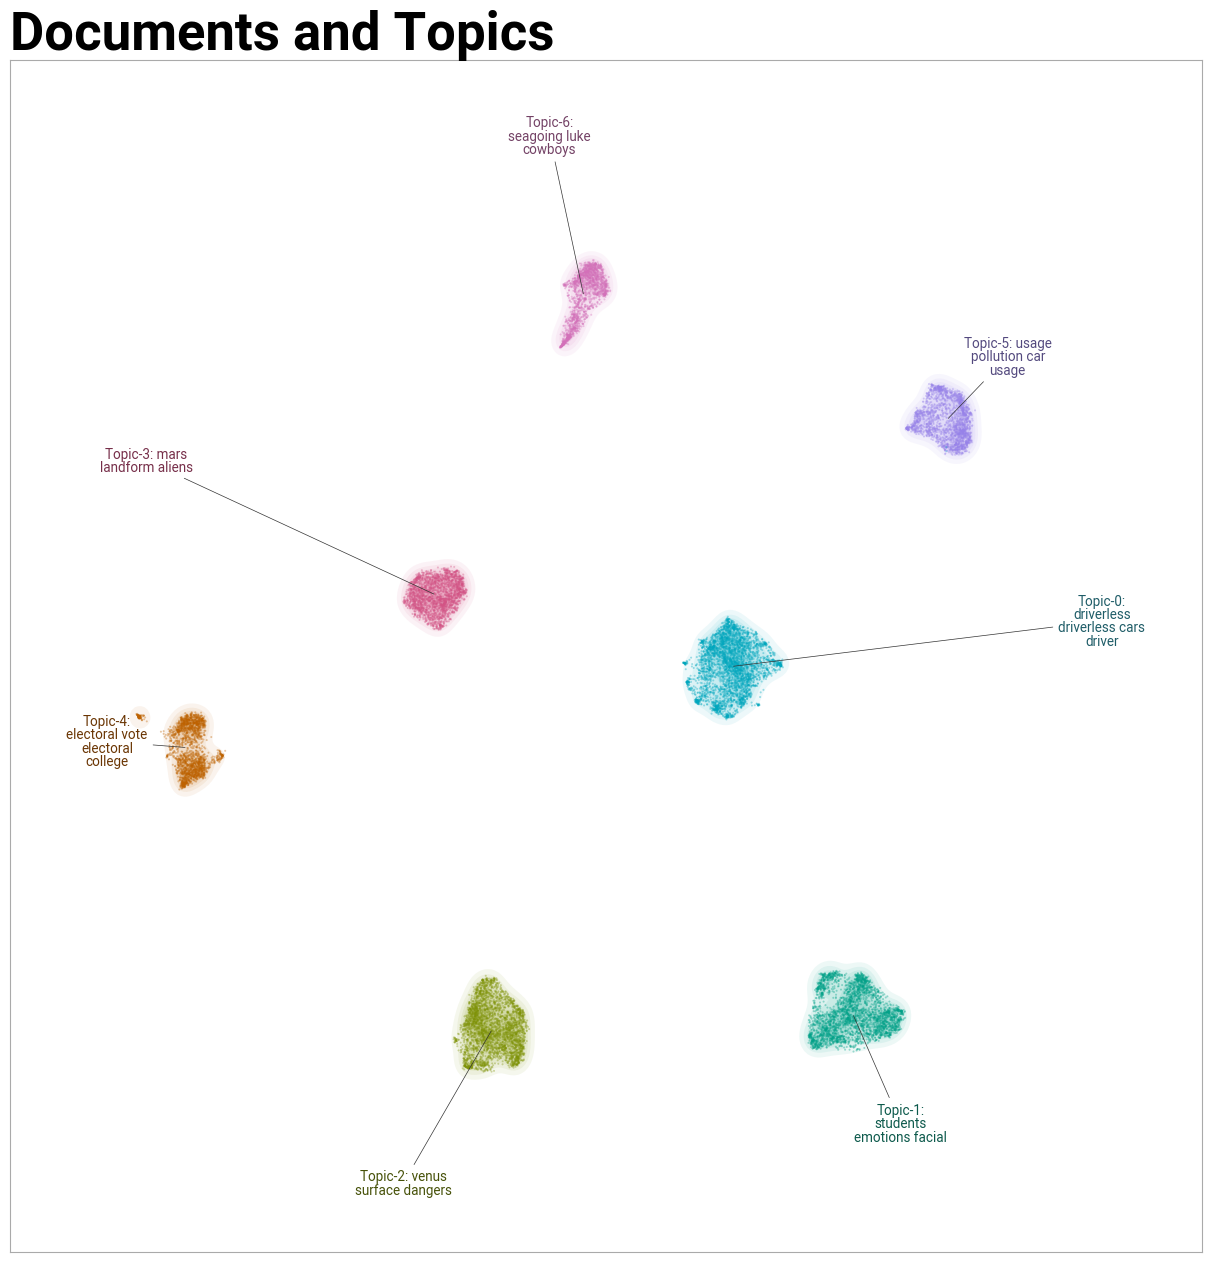

In [22]:
# `topic_distr` contains the distribution of topics in each document
_ = topic_model.visualize_document_datamap(
    train_df["full_text"],
    reduced_embeddings=reduced_embeddings,
)

In [23]:
topics = topic_model.transform(train_df["full_text"])

Batches:   0%|          | 0/541 [00:00<?, ?it/s]

2024-05-31 18:40:43,428 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-05-31 18:40:43,458 - BERTopic - Dimensionality - Completed ✓
2024-05-31 18:40:43,458 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-05-31 18:40:44,537 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-05-31 18:40:46,547 - BERTopic - Probabilities - Completed ✓
2024-05-31 18:40:46,547 - BERTopic - Cluster - Completed ✓


In [24]:
train_df["topic"] = topics[0]

### Distribution of Topics

In [25]:
distribution_df = train_df.loc[:, ["topic", "score"]].value_counts().reset_index()

In [40]:
px.bar(
    distribution_df,
    x="score",
    y="count",
    color="topic",
    text_auto=True,
    text="count",
    color_continuous_scale="Viridis",
    title="Topic wise distribution of scores"
)

In [27]:
topic_model.save("output/BERTopic/topic_model.pkl", serialization="pickle", save_ctfidf=True)
pkl.dump(embedding_model, open("output/BERTopic/embedding_model.pkl", "wb"))
pkl.dump(umap_model, open("output/BERTopic/umap.pkl", "wb"))
pkl.dump(hdbscan_model, open("output/BERTopic/hdbscan.pkl", "wb"))
pkl.dump(vectorizer_model, open("output/BERTopic/vectorizer.pkl", "wb"))
pkl.dump(representation_model, open("output/BERTopic/representation_model.pkl", "wb"))

2024-05-31 18:40:46,711 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
